## Imports

In [1]:
#!pip install -U dill==0.3.5.1
#!pip install -U tensorflow-io==0.27.0
#!pip install -U tensorflow-transform==1.11.0
#!pip install -U tensorflow==2.10.0
import tensorflow as tf
print(tf.__version__)

2022-12-18 11:47:31.393972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 11:47:31.501503: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-18 11:47:31.959385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-18 11:47:31.959431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

2.10.0


In [2]:
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings

In [3]:
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

plt.rc('font', size=16)

tfk = tf.keras
tfkl = tf.keras.layers

## Defines

### Seed

In [4]:
# Random seed for reproducibility
seed = 1337

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Constants

#### Imports

In [5]:
dataset_location = '../../input/training_dataset_homework2/'
x_name = 'x_train.npy'
y_name = 'y_train.npy'

#### Training

In [6]:
classes = 12
input_shape = (None, 6)

batch_size = 64
epochs = 200

label_mapping = {
    "Wish" : 0,
    "Another" : 1,
    "Comfortably" : 2,
    "Money" : 3,
    "Breathe" : 4,
    "Time" : 5,
    "Brain" : 6,
    "Echoes" : 7,
    "Wearing" : 8,
    "Sorrow" : 9,
    "Hey" : 10,
    "Shine" : 11
}

### Utility Functions

In [7]:
def build_sequences(x, y, window):
    
    dataset = []
    labels = []
    
    for sample, label in zip(x,y):
        n_new_samples = sample.shape[0] - window + 1
        
        for i in range(n_new_samples):
            dataset.append(sample[i:window+i,:])
            labels.append(label)
        
    return np.array(dataset), np.array(labels)

In [8]:
def inspect_multivariate(x, y, idx=None):
    if(idx == None):
        idx = np.random.randint(0, len(x))
    print(f"{y[idx]} --> {np.argmax(y[idx])}")
    df = pd.DataFrame(x[idx,:,:])
    df.plot(subplots=True, figsize=(17, 9))
    plt.show()

In [9]:
def inspect_timewise(total):
    vis = np.transpose(np.concatenate(total))
    plt.rcParams["figure.figsize"] = [15, 30]
    plt.rcParams["figure.autolayout"] = True
    fig, axs = plt.subplots(6)
    for idx in range(6):
        df = pd.DataFrame(vis[idx,:])
        axs[idx].plot(df)
        l=0
        for i in label_counts:
            l = l + i*36
            axs[idx].axvline(l, color='red')
        axs[idx].text(s = f"Feature {idx+1}", x = 80000, y = 30000)
    plt.show()

In [10]:
def evaluate_classes_performance(model, x_val, y_val):
    data_list = []
    label_list = []
    batch_index = 0

    data_array = np.array(x_val)
    label_array = np.array(y_val)   
    label_values = np.argmax(label_array, axis=1)
    predictions = model.predict(data_array)
    predictions_label = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions_label)
    print(report)
    
    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

In [11]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

## Load dataset

In [12]:
x_total = np.load(dataset_location + x_name)
y_total = np.load(dataset_location + y_name)

### Preprocessing

In [13]:
# Weight classes
class_weights = {}
_, label_counts = np.unique(y_total, return_counts=True)
class_mean = sum(label_counts) / len(label_counts)
for i, n in enumerate(label_counts):
    class_weights[i] = (1 / n) * class_mean
print(class_weights)

{0: 5.953431372549019, 1: 1.6456639566395665, 2: 0.7496913580246913, 3: 0.5312773403324584, 4: 3.264784946236559, 5: 1.3229847494553377, 6: 0.6466986155484558, 7: 2.9767156862745097, 8: 1.6868055555555554, 9: 0.2605105105105105, 10: 2.628787878787879, 11: 3.9689542483660127}


In [14]:
x_train, x_val, y_train, y_val = train_test_split(
    x_total,
    y_total,
    test_size=0.2,
    random_state=seed
)

In [15]:
# Norm on the 36-dimension
# x_val /= np.max(np.abs(x_train), axis=0)
# x_train /= np.max(np.abs(x_train), axis=0)

# Norm on the 6-dimension
# x_val /= np.max(np.max(np.abs(x_train), axis=0))
# x_train /= np.max(np.max(np.abs(x_train), axis=0))

In [16]:
x_train, y_train = build_sequences(x_train, y_train, 34)

In [17]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

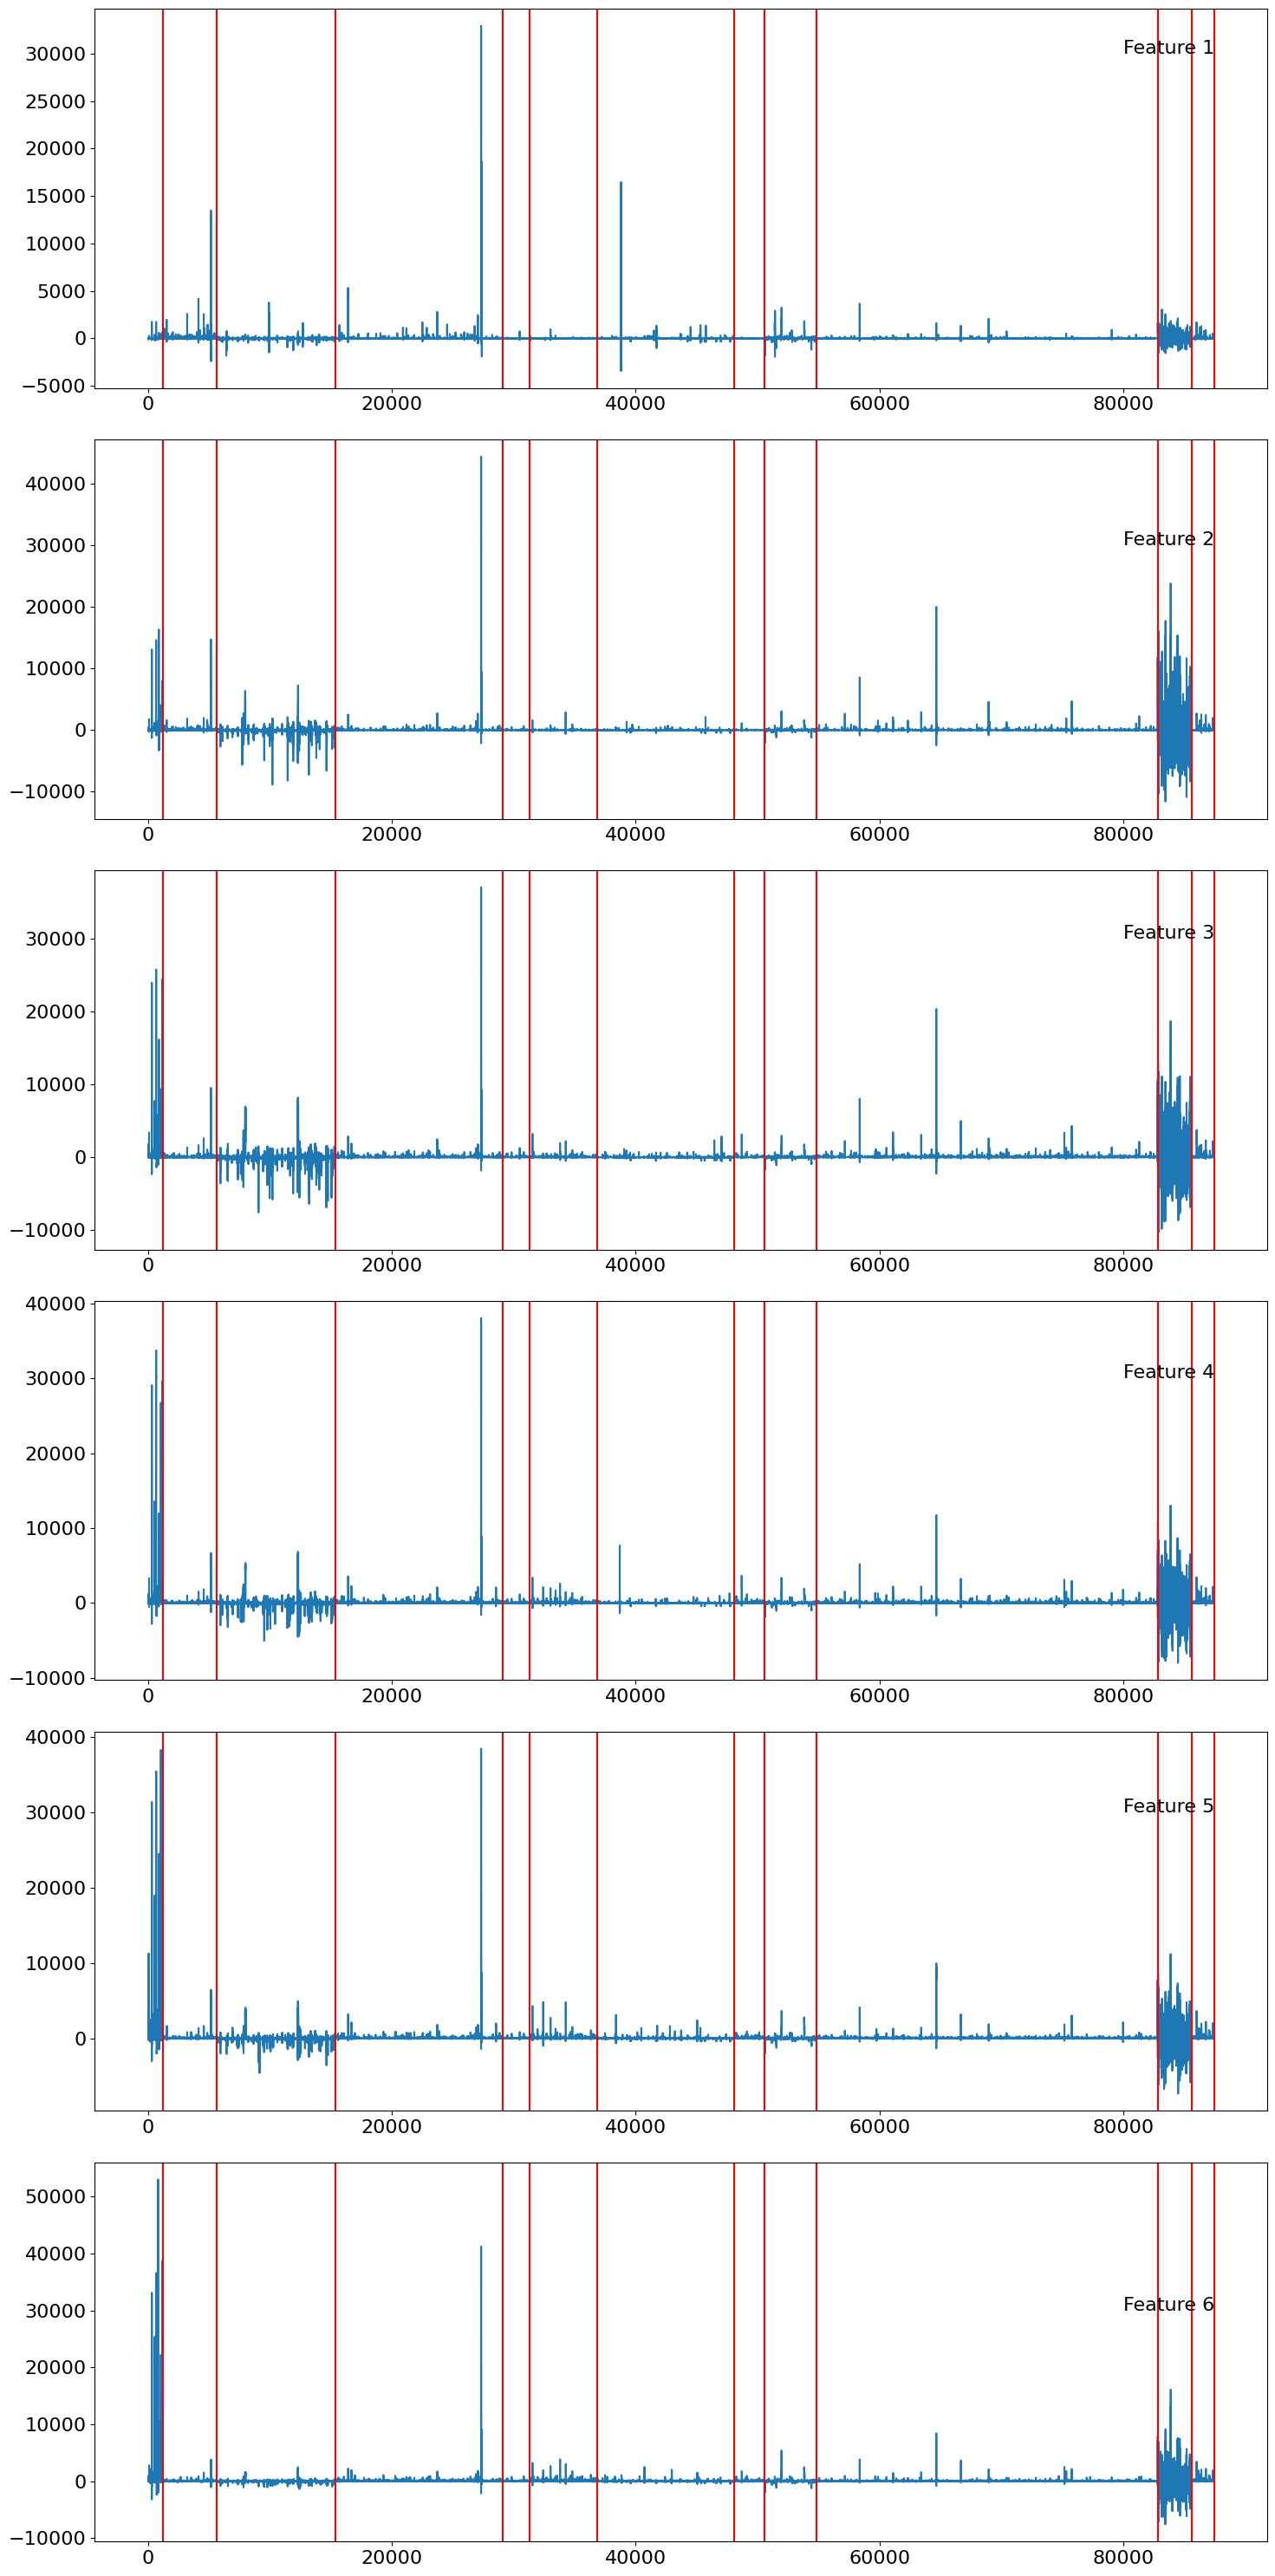

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] --> 9


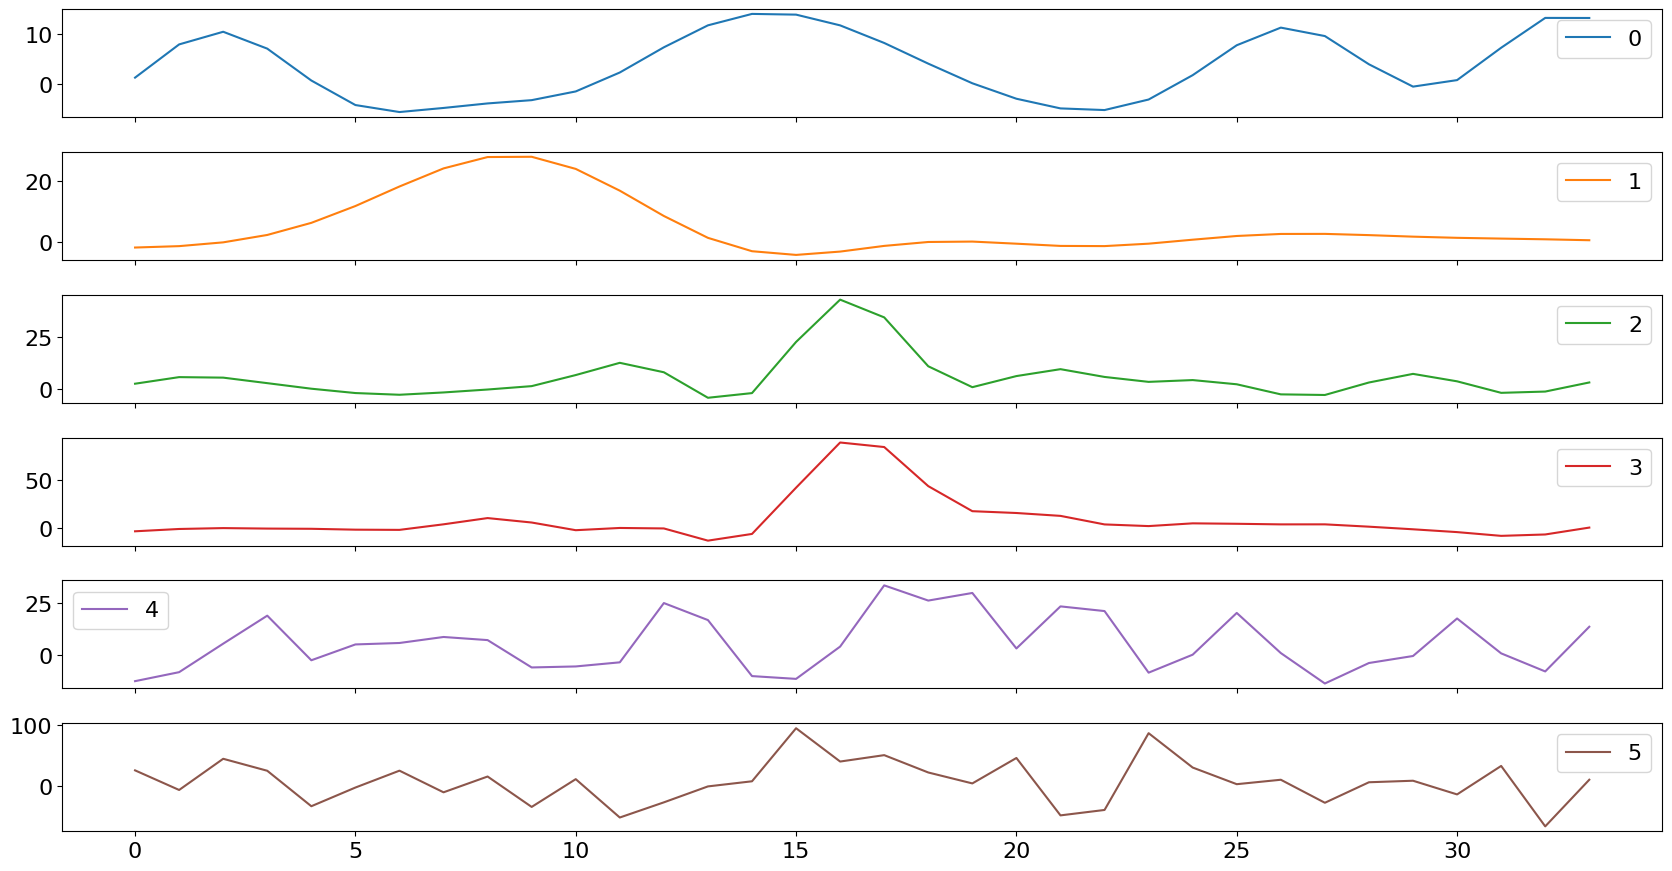

In [18]:
inspect_timewise(x_total)
inspect_multivariate(x_train, y_train)


## Model

In [19]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Preprocessing
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)
    
    # Feature extractor
    lstm = pre
    lstm = tfkl.LSTM(256, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(256)(lstm)
    lstm = tfkl.Dropout(.5, seed=seed)(lstm)
    
    # Classifier
    classifier = lstm
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [20]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Preprocessing
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)

    # Feature extractor
    bilstm = pre
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256))(bilstm)
    bilstm = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = bilstm
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [40]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)
    

    # Feature extractor
    cnn = pre
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(pre)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    #cnn = tfkl.MaxPooling1D()(cnn)
    #cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    #cnn = tfkl.MaxPooling1D()(cnn)
    #cnn = tfkl.Conv1D(256, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    # Classifier
    classifier = cnn
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [41]:
# MEH
def build_supernet_classifier(input_shape, classes):
    supernet = tfk.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        #input_shape=input_shape
    )
    
    supernet.trainable = True
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    x = tfkl.Reshape((72, 1, 3))(input_layer)
    x = tfkl.Resizing(32, 32)(x)
    # x = input_layer
    
    cnn = supernet(x)
    
    gap = tfkl.GlobalAveragePooling2D()(cnn)
    
    x = tfkl.Dropout(0.3, seed=seed)(gap)
    x = tfkl.Dense(
        256, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(0.3, seed=seed)(x)
    x = tfkl.Dense(
        256, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    classifier = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [42]:
# model = build_LSTM_classifier(input_shape, classes)
# model = build_BiLSTM_classifier(input_shape, classes)
model = build_1DCNN_classifier(input_shape, classes)   # BEST ONE
# model = build_supernet_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 6)]         0         
                                                                 
 Norm (Normalization)        (None, None, 6)           13        
                                                                 
 conv1d_16 (Conv1D)          (None, None, 128)         2432      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, None, 128)         49280     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                        

## Training

### Adapt preprocessing layers

In [43]:
model.get_layer("Norm").adapt(x_train)

### Train

In [44]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    #class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
92/92 [==============================] - 1s 6ms/step - loss: 2.0742 - accuracy: 0.3555 - val_loss: 1.9455 - val_accuracy: 0.3457 - lr: 0.0010
Epoch 2/200
92/92 [==============================] - 0s 5ms/step - loss: 1.7893 - accuracy: 0.4086 - val_loss: 1.7469 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 3/200
92/92 [==============================] - 0s 5ms/step - loss: 1.6377 - accuracy: 0.4443 - val_loss: 1.5286 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 4/200
92/92 [==============================] - 0s 5ms/step - loss: 1.5190 - accuracy: 0.4843 - val_loss: 1.4618 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 5/200
92/92 [==============================] - 0s 5ms/step - loss: 1.4018 - accuracy: 0.5244 - val_loss: 1.3511 - val_accuracy: 0.5514 - lr: 0.0010
Epoch 6/200
92/92 [==============================] - 0s 5ms/step - loss: 1.3094 - accuracy: 0.5529 - val_loss: 1.3294 - val_accuracy: 0.5576 - lr: 0.0010
Epoch 7/200
92/92 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 54/200
92/92 [==============================] - 0s 5ms/step - loss: 0.5245 - accuracy: 0.8175 - val_loss: 1.2051 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 55/200
92/92 [==============================] - 0s 5ms/step - loss: 0.5347 - accuracy: 0.8128 - val_loss: 1.2414 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 56/200
92/92 [==============================] - 0s 5ms/step - loss: 0.5394 - accuracy: 0.8120 - val_loss: 1.0618 - val_accuracy: 0.7058 - lr: 0.0010
Epoch 57/200
92/92 [==============================] - 1s 6ms/step - loss: 0.5281 - accuracy: 0.8137 - val_loss: 1.2165 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 58/200
92/92 [==============================] - 0s 5ms/step - loss: 0.5249 - accuracy: 0.8166 - val_loss: 1.0960 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 59/200
92/92 [==============================] - 0s 5ms/step - loss: 0.4857 - accuracy: 0.8331 - val_loss: 1.0704 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 60/200
92/92 [==============================] - 0s 5ms/step - lo

Epoch 106/200
92/92 [==============================] - 0s 5ms/step - loss: 0.1966 - accuracy: 0.9357 - val_loss: 1.6369 - val_accuracy: 0.7428 - lr: 2.5000e-04
Epoch 107/200
92/92 [==============================] - 0s 5ms/step - loss: 0.1963 - accuracy: 0.9370 - val_loss: 1.6674 - val_accuracy: 0.7510 - lr: 2.5000e-04
Epoch 108/200
92/92 [==============================] - 1s 5ms/step - loss: 0.1840 - accuracy: 0.9434 - val_loss: 1.6623 - val_accuracy: 0.7428 - lr: 2.5000e-04
Epoch 109/200
92/92 [==============================] - 1s 5ms/step - loss: 0.1815 - accuracy: 0.9458 - val_loss: 1.6456 - val_accuracy: 0.7449 - lr: 2.5000e-04
Epoch 110/200
92/92 [==============================] - 0s 5ms/step - loss: 0.1873 - accuracy: 0.9370 - val_loss: 1.6855 - val_accuracy: 0.7469 - lr: 2.5000e-04
Epoch 111/200
92/92 [==============================] - 0s 5ms/step - loss: 0.1886 - accuracy: 0.9398 - val_loss: 1.7160 - val_accuracy: 0.7490 - lr: 2.5000e-04
Epoch 112/200
92/92 [===================

## Visualize Results

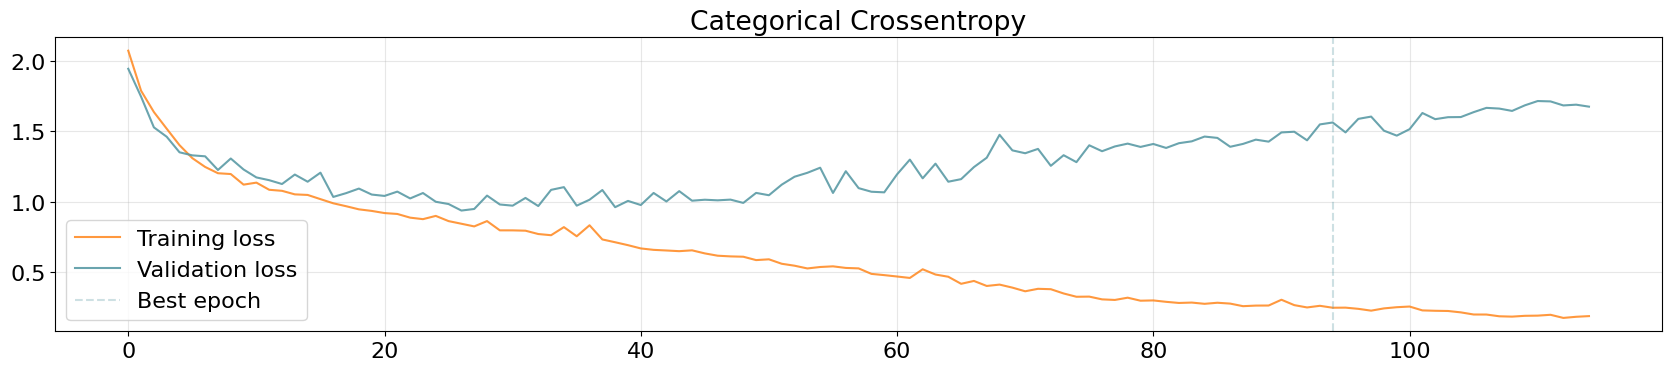

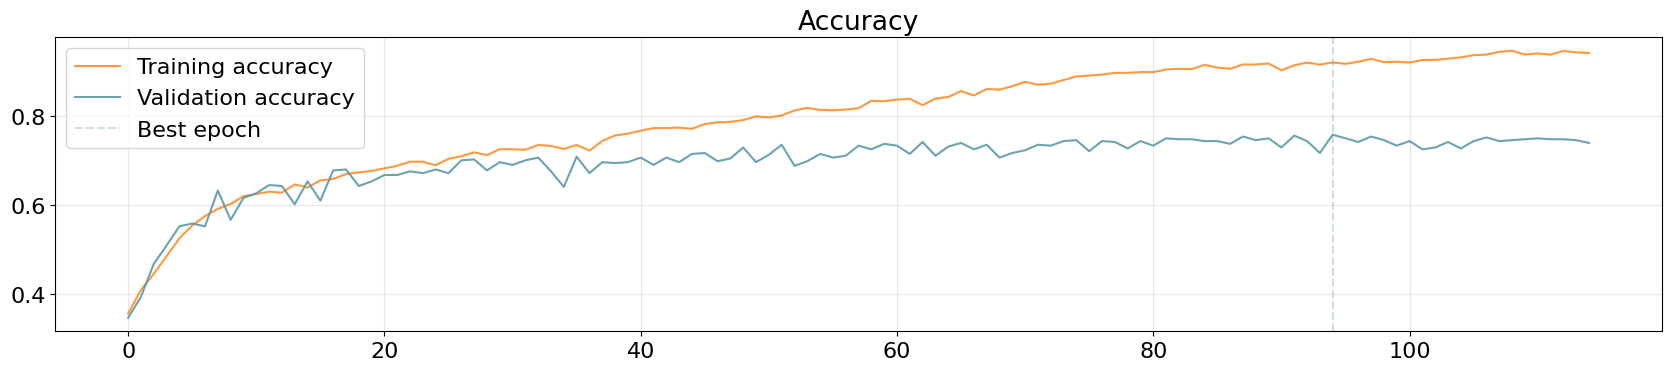

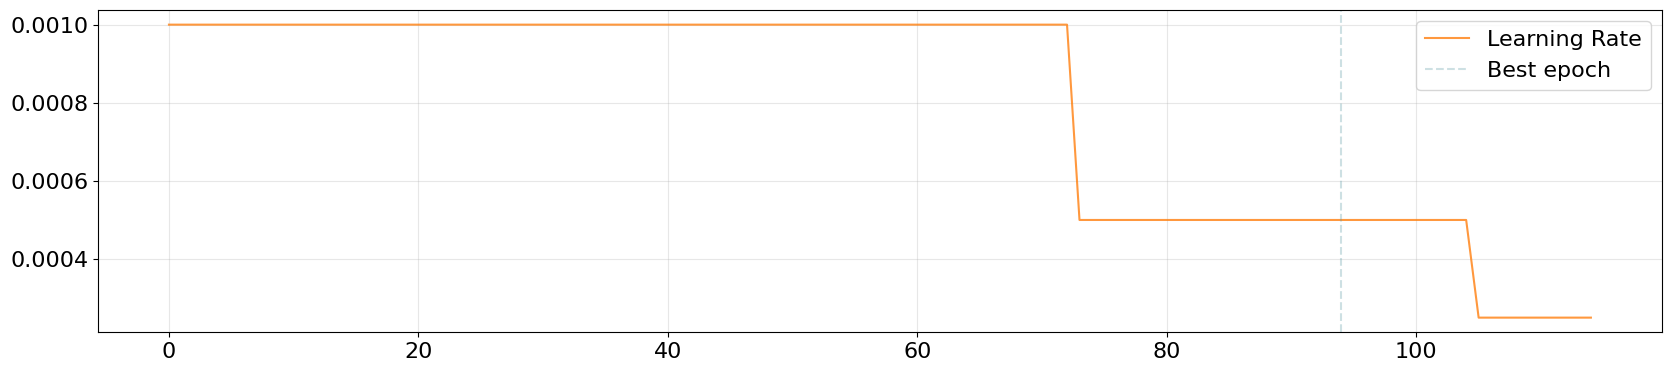

In [45]:
plot_history(history)

16/16 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.55      0.71      0.62        34
           2       0.98      0.96      0.97        54
           3       0.62      0.63      0.63        73
           4       0.00      0.00      0.00        10
           5       0.48      0.44      0.46        32
           6       0.86      0.89      0.88        56
           7       0.57      0.33      0.42        12
           8       0.95      0.95      0.95        38
           9       0.76      0.84      0.80       144
          10       1.00      0.94      0.97        16
          11       0.75      0.38      0.50         8

    accuracy                           0.76       486
   macro avg       0.71      0.62      0.64       486
weighted avg       0.75      0.76      0.75       486

Accuracy: 0.7572
Precision: 0.7098
Recall: 0.6163
F1: 0.6401


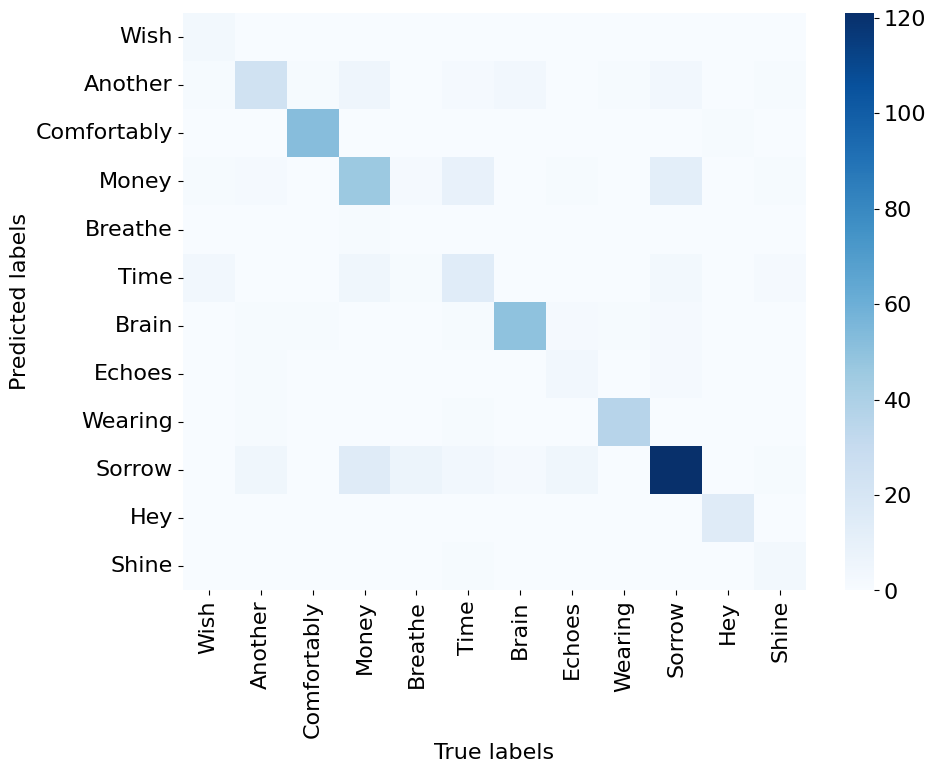

In [46]:
evaluate_classes_performance(model, x_val, y_val)

## Save

In [47]:
#import shutil
model.save('El_Dudo')
#shutil.make_archive("ANN_Homework2_Model", 'zip', '/kaggle/working/ANN_Homework2_Model')